In [1]:
from time import time

import matplotlib.pyplot as plt
from scipy.stats import loguniform

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC
from concrete.ml.sklearn.svm import LinearSVC

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
n_components = 150

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 2.984s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.210s


In [5]:
# print("Fitting the classifier to the training set")
# t0 = time()
# param_grid = {
#     "C": loguniform(1e3, 1e5),
#     "gamma": loguniform(1e-4, 1e-1),
# }
# clf = RandomizedSearchCV(
#     SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
# )

# clf = clf.fit(X_train_pca, y_train)
# print("done in %0.3fs" % (time() - t0))
# print("Best estimator found by grid search:")
# print(clf.best_estimator_)

In [6]:
from concrete.ml.sklearn.svm import LinearSVC
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV
from time import time

print("Fitting the classifier to the training set")
t0 = time()

# Define the parameter grid for LinearSVC
param_grid = {
    "C": loguniform(1e-3, 1e3),  # Adjusted range for C to suit LinearSVC
}

# Use Concrete ML's LinearSVC
clf = RandomizedSearchCV(
    LinearSVC(class_weight="balanced", max_iter=5000),  # Increased max_iter
    param_grid,
    n_iter=10
)
# Fit the model
clf = clf.fit(X_train_pca, y_train)

print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 21.157s
Best estimator found by grid search:
LinearSVC(C=0.0018131017577531902, class_weight='balanced', max_iter=5000)


Predicting people's names on the test set
done in 0.001s
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.77      0.65        13
     Colin Powell       0.83      0.88      0.85        60
  Donald Rumsfeld       0.72      0.67      0.69        27
    George W Bush       0.96      0.88      0.92       146
Gerhard Schroeder       0.67      0.80      0.73        25
      Hugo Chavez       0.59      0.67      0.62        15
       Tony Blair       0.85      0.81      0.83        36

         accuracy                           0.84       322
        macro avg       0.74      0.78      0.76       322
     weighted avg       0.85      0.84      0.84       322



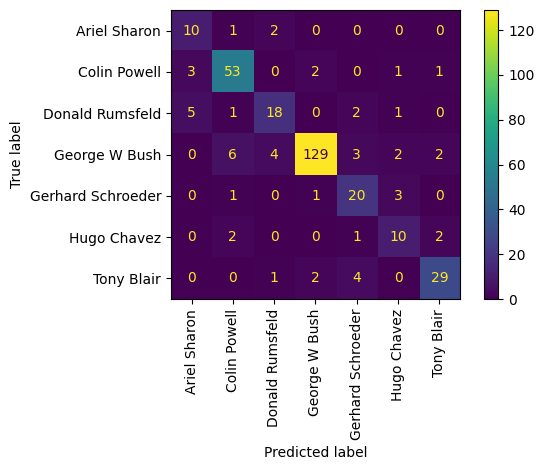

In [7]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

In [8]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

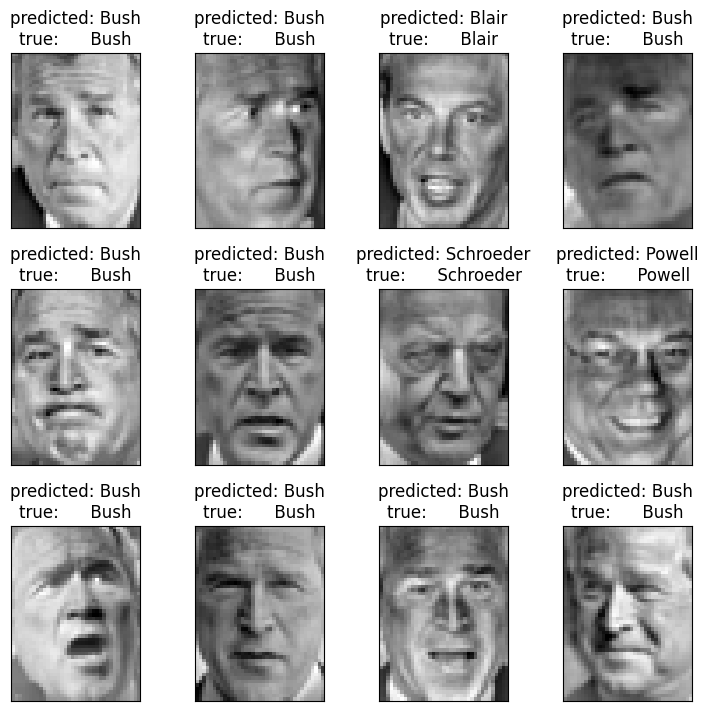

In [9]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

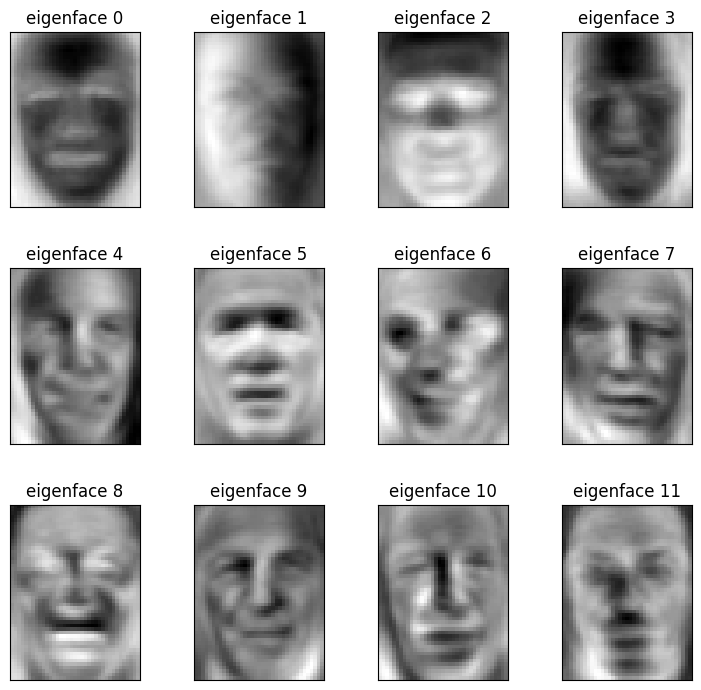

In [10]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

In [35]:
import os
import shutil
from concrete.ml.deployment import FHEModelClient

# Access the best estimator from RandomizedSearchCV
best_model = clf.best_estimator_

# Compile the model for encrypted inference
print("Compiling the model for encrypted inference...")
best_model.compile(X_train_pca)
print("Model compiled successfully!")


best_model.predict(X_test_pca[:5])



Compiling the model for encrypted inference...
Model compiled successfully!


[cctools-port]: generating fake signature for '/var/folders/c9/8rc_zy1n66b9fv9658s4z6g00000gn/T/tmphwne81rd/sharedlib.dylib'


array([3, 3, 6, 3, 3])

Performing predictions on the entire test set...
done in 0.002s
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.77      0.65        13
     Colin Powell       0.83      0.88      0.85        60
  Donald Rumsfeld       0.72      0.67      0.69        27
    George W Bush       0.96      0.88      0.92       146
Gerhard Schroeder       0.67      0.80      0.73        25
      Hugo Chavez       0.59      0.67      0.62        15
       Tony Blair       0.85      0.81      0.83        36

         accuracy                           0.84       322
        macro avg       0.74      0.78      0.76       322
     weighted avg       0.85      0.84      0.84       322



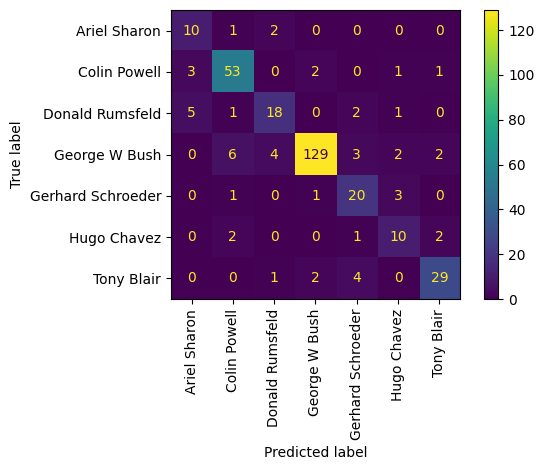

In [36]:
print("Performing predictions on the entire test set...")
t0 = time()

# Predict for the entire test set
y_pred = best_model.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

# Evaluate the predictions
print(classification_report(y_test, y_pred, target_names=target_names))

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

Predicting people's names on the test set...
done in 0.002s


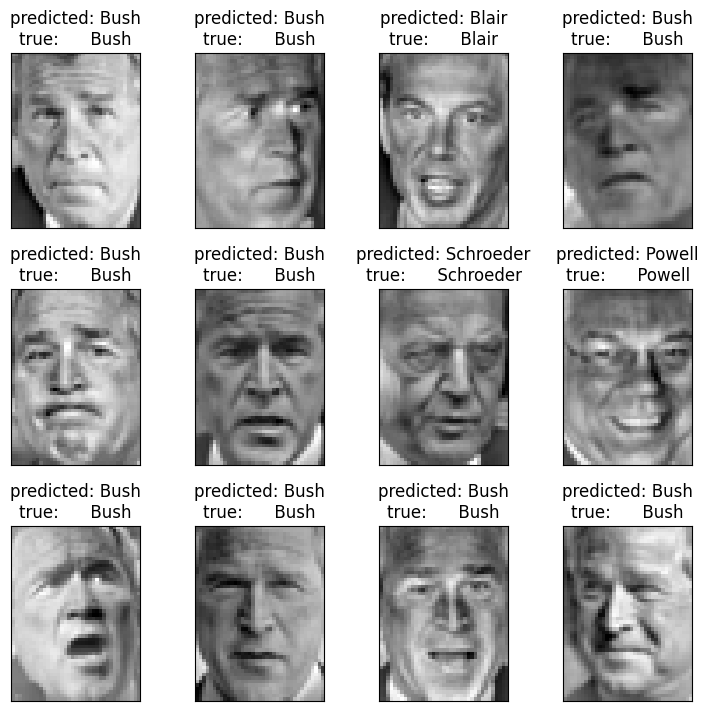

In [ ]:

print("Predicting people's names on the test set...")
t0 = time()
y_pred = best_model.predict(X_test_pca)  # Predict for all test samples
print("done in %0.3fs" % (time() - t0))

# Generate titles for all predictions
prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

# Plot the gallery with predictions and true labels for all test samples
plot_gallery(X_test, prediction_titles, h, w)
plt.show()